# Read in the Raw Data, Load the YAML metadata, and Clean the Data

In [1]:
# Import the required modules

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np
import scipy as sp

import yaml
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin


In [2]:
# Read in the raw CSV data, and then print the count of observations and variables
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_1321_puf.csv

raw_df = pd.read_csv('nsmo_v50_1321_puf.csv')
raw_df.shape

(50542, 543)

In [3]:
# Load YAML files containing metadata into Python as dictionaries

# Load the labels of each variable into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_labels.sas

with open('variable_labels.yaml', 'r') as file:
    variable_labels_dict = yaml.safe_load(file)
    
# Load the the format of each variable into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_labels.sas

with open('variable_formats.yaml', 'r') as file:
    variable_formats_dict = yaml.safe_load(file)
    
# Load the categories for every categorical variable (exclude null categories) into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_formats.sas

with open('categorical_variables_categories.yaml', 'r') as file:
    categorical_variables_categories_dict = yaml.safe_load(file)

In [4]:
# Clean data by converting negative values and "." values (representing missing values) into null values (i.e., NaN)

excluded_columns = ['PSTATFM', 'rate_spread']

for col in raw_df.columns:
    if variable_formats_dict[col] != 'PSTATFM' and col != 'rate_spread':
        raw_df.loc[raw_df[col] < 0, col] = np.nan
        raw_df.loc[raw_df[col] == ".", col] = np.nan

In [5]:
# Check out a few obs after data cleaning

raw_df.tail()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.000,34.000,2117.790,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,64.000,61.000,59.000,59.000,59.000,59.000,59.000,60.000
50538,546643.000,34.000,1738.920,3.000,3.000,2.000,2.000,2.000,1.000,3.000,...,NaN,NaN,79.000,77.000,74.000,72.000,72.000,71.000,71.000,71.000
50539,512993.000,34.000,2353.260,1.000,2.000,2.000,2.000,2.000,1.000,2.000,...,NaN,NaN,95.000,91.000,88.000,85.000,84.000,84.000,83.000,82.000
50540,518631.000,34.000,5283.750,3.000,3.000,3.000,3.000,3.000,3.000,3.000,...,NaN,NaN,56.000,53.000,50.000,49.000,49.000,49.000,48.000,48.000
50541,544740.000,34.000,1738.920,1.000,1.000,1.000,1.000,1.000,1.000,2.000,...,NaN,NaN,80.000,74.000,69.000,66.000,65.000,64.000,63.000,63.000


In [6]:
# Create a set of all variable formats

variable_formats_set = set(variable_formats_dict.values())

In [7]:
# Create a list of the categorical variables and a list of the numeric variables

categorical_variables = []
numeric_variables = []

categorical_variable_formats = set(categorical_variables_categories_dict.keys())
numeric_variable_formats = variable_formats_set - categorical_variable_formats

for col in raw_df.columns:
    if variable_formats_dict[col] in categorical_variable_formats:
        categorical_variables.append(col)
    elif variable_formats_dict[col] in numeric_variable_formats:
        numeric_variables.append(col)
    else:
        print("Error in bifurcation")

In [8]:
raw_df.tail()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.000,34.000,2117.790,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,64.000,61.000,59.000,59.000,59.000,59.000,59.000,60.000
50538,546643.000,34.000,1738.920,3.000,3.000,2.000,2.000,2.000,1.000,3.000,...,NaN,NaN,79.000,77.000,74.000,72.000,72.000,71.000,71.000,71.000
50539,512993.000,34.000,2353.260,1.000,2.000,2.000,2.000,2.000,1.000,2.000,...,NaN,NaN,95.000,91.000,88.000,85.000,84.000,84.000,83.000,82.000
50540,518631.000,34.000,5283.750,3.000,3.000,3.000,3.000,3.000,3.000,3.000,...,NaN,NaN,56.000,53.000,50.000,49.000,49.000,49.000,48.000,48.000
50541,544740.000,34.000,1738.920,1.000,1.000,1.000,1.000,1.000,1.000,2.000,...,NaN,NaN,80.000,74.000,69.000,66.000,65.000,64.000,63.000,63.000


In [9]:
# Check out a few obs for just the categorical variable

raw_df[categorical_variables].tail()

,x05a,x05b,x05c,x05d,x05e,x05f,x05g,x06,x07,x08a,...,forb0621,forb0921,forb1221,forb0322,forb0622,forb0922,forb1222,forb0323,forb0623,forb0923
50537,1.000,1.000,1.000,1.000,1.000,1.000,1.000,3.000,2.000,1.000,...,NaN,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000
50538,3.000,3.000,2.000,2.000,2.000,1.000,3.000,3.000,3.000,2.000,...,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000,2.000
50539,1.000,2.000,2.000,2.000,2.000,1.000,2.000,3.000,2.000,1.000,...,NaN,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000
50540,3.000,3.000,3.000,3.000,3.000,3.000,3.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000
50541,1.000,1.000,1.000,1.000,1.000,1.000,2.000,3.000,2.000,1.000,...,NaN,NaN,NaN,2.000,2.000,2.000,2.000,2.000,2.000,2.000


In [10]:
# Check out a few obs for just the numeric variable

raw_df[numeric_variables].tail()

,nsmoid,survey_wave,analysis_weight,x74r,rate_spread,pmms,term,ltv,cltv,dti,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.000,34.000,2117.790,57.000,0.640,3.110,40.000,64.000,64.000,42.000,...,NaN,NaN,64.000,61.000,59.000,59.000,59.000,59.000,59.000,60.000
50538,546643.000,34.000,1738.920,37.000,0.030,3.100,30.000,79.000,79.000,33.000,...,NaN,NaN,79.000,77.000,74.000,72.000,72.000,71.000,71.000,71.000
50539,512993.000,34.000,2353.260,26.000,-0.230,3.100,30.000,95.000,95.000,35.000,...,NaN,NaN,95.000,91.000,88.000,85.000,84.000,84.000,83.000,82.000
50540,518631.000,34.000,5283.750,36.000,-0.230,3.100,20.000,56.000,56.000,46.000,...,NaN,NaN,56.000,53.000,50.000,49.000,49.000,49.000,48.000,48.000
50541,544740.000,34.000,1738.920,42.000,0.080,3.050,30.000,80.000,80.000,20.000,...,NaN,NaN,80.000,74.000,69.000,66.000,65.000,64.000,63.000,63.000


In [11]:
# View survey answers for any given observation in a human readable format using the YAML metadata
# Deactivated code below because it will print 500+ lines because we have 500+ variables

if False:
    one_obs = raw_df.iloc[50541]
    # Loop through all columns for one obs
    for col, value in one_obs.items():
        # if it's a categorical variable, then look up the category
        if not(pd.isna(value)) and col in categorical_variables:
            print(variable_labels_dict[col], ":", categorical_variables_categories_dict[variable_formats_dict[col]][value])
        # else it's a numeric variable or null
        else:
            print(variable_labels_dict[col], ":", value)

# Join with External Data: 30-year Treasury Yields (i.e., the Risk-Free Rate)

In [12]:
# Read in the raw CSV data for Market Yields on U.S. Treasury Securities at 30-Year Constant Maturity
# https://fred.stlouisfed.org/series/DGS30

treasury_yields_df = pd.read_csv('DGS30.csv')

In [13]:
# Create new columns based upon the observation date, which will be used in join to the main data

treasury_yields_df['observation_date'] = pd.to_datetime(treasury_yields_df['observation_date'])
treasury_yields_df['observation_year'] = treasury_yields_df['observation_date'].dt.year
treasury_yields_df['observation_month'] = treasury_yields_df['observation_date'].dt.month

In [14]:
# Check out the daily obsevations of DGS30, which represents the 30-year Treasury Yield (i.e., the Risk-Free Rate)

treasury_yields_df.tail()

,observation_date,DGS30,observation_year,observation_month
2343,2021-12-27,1.880,2021,12
2344,2021-12-28,1.900,2021,12
2345,2021-12-29,1.960,2021,12
2346,2021-12-30,1.930,2021,12
2347,2021-12-31,1.900,2021,12


In [15]:
# Calculate the average Treasury Yields over each Year and Month

average_treasury_yields_df = treasury_yields_df.groupby(['observation_year', 'observation_month'])['DGS30'].mean()
average_treasury_yields_df = average_treasury_yields_df.to_frame().reset_index()

In [16]:
# Check out the average Treasury Yields over each Year and Month

average_treasury_yields_df.head()

,observation_year,observation_month,DGS30
0,2013,1,3.080
1,2013,2,3.165
2,2013,3,3.163
3,2013,4,2.933
4,2013,5,3.113


In [17]:
# Left join the Treasury Yields to the raw Mortgage Origination data using the composite keys of year and month

merged_df = pd.merge(left=raw_df, 
                     right=average_treasury_yields_df,
                     left_on=['open_year', 'open_month'],
                     right_on=['observation_year', 'observation_month'],
                     how='left')

# Drop the redundant columns of composite keys used in join

merged_df = merged_df.drop(['observation_year', 'observation_month'], axis=1)

In [18]:
# Check out the data after the left join

merged_df.head()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923,DGS30
0,509550.000,1.000,1207.580,3.000,3.000,3.000,3.000,3.000,1.000,3.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080
1,503017.000,1.000,1207.580,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.165
2,514904.000,1.000,1027.740,1.000,2.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080
3,525176.000,1.000,1711.910,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080
4,540654.000,1.000,918.850,1.000,1.000,2.000,1.000,2.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080


In [19]:
# Derivation of Beta, which is a new variable

notes = """
Re = Rf + β(Rm − Rf)
Re - Rf = β(Rm − Rf)
(Re - Rf) = β(Rm − Rf)
(Re - Rf) / (Rm − Rf) = β
β = (Re - Rf) / (Rm − Rf)

'rate_spread' = Re - 'PMMS'
'rate_spread' + 'PMMS' = Re 
Re = 'rate_spread' + 'PMMS'

β = ('rate_spread' + 'PMMS' - Rf) / (Rm − Rf)
β = ('rate_spread' + 'PMMS' - 'treasury_yield') / ('PMMS' − 'treasury_yield')
"""

In [20]:
# Calculation: Beta = ('rate_spread' + 'pmms' - 'treasury_yield') / ('pmms' − 'treasury_yield')

merged_df['Beta'] = (merged_df['rate_spread'] + merged_df['pmms'] - merged_df['DGS30']) / (merged_df['pmms'] - merged_df['DGS30'])

In [21]:
# Describe the distribution of Beta

merged_df['Beta'].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count        50542.000
mean       -135974.001
std        7048940.930
min     -656705858.722
1%              -8.000
5%              -0.271
10%              0.421
25%              0.855
50%              1.121
75%              1.438
90%              2.001
95%              2.797
99%              7.612
max      182151991.288
Name: Beta, dtype: float64

In [22]:
# Winsorize the Beta values to reduce the influence of outliers
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html

merged_df['Beta_winsorized'] = sp.stats.mstats.winsorize(merged_df['Beta'], limits=[0.05,0.05])

In [23]:
# Append the new numeric variables to the list of all numeric variables

numeric_variables.append('DGS30')
numeric_variables.append('Beta')
numeric_variables.append('Beta_winsorized')

# Process the Data using Dummy Coding, Partitioning, Imputing, and then Scaling

In [24]:
# Create dummy variables for each category for each categorical variable

processed_df = pd.get_dummies(merged_df, columns=categorical_variables)

In [25]:
# Remove the ".0" in many of the dummy variable due to the columns in the raw data being floats

new_columns_list = []
for col in processed_df.columns:
    new_col = col.replace(".0", "")
    new_columns_list.append(new_col)
    
processed_df.columns = new_columns_list

In [26]:
# Retrieve the names of the new categorical variables (i.e., the dummy variables)

new_categorical_variables = []
for col in processed_df.columns:
    if col not in numeric_variables:
        new_categorical_variables.append(col)

In [27]:
# Check out a few obs for just the new categorical variable

processed_df[new_categorical_variables].tail()

,x05a_1,x05a_2,x05a_3,x05b_1,x05b_2,x05b_3,x05c_1,x05c_2,x05c_3,x05d_1,...,forb0922_1,forb0922_2,forb1222_1,forb1222_2,forb0323_1,forb0323_2,forb0623_1,forb0623_2,forb0923_1,forb0923_2
50537,True,False,False,True,False,False,True,False,False,True,...,False,True,False,True,False,True,False,True,False,True
50538,False,False,True,False,False,True,False,True,False,False,...,False,True,False,True,False,True,False,True,False,True
50539,True,False,False,False,True,False,False,True,False,False,...,False,True,False,True,False,True,False,True,False,True
50540,False,False,True,False,False,True,False,False,True,False,...,False,True,False,True,False,True,False,True,False,True
50541,True,False,False,True,False,False,True,False,False,True,...,False,True,False,True,False,True,False,True,False,True


In [28]:
# Identify the target variable

target_variable = 'Beta_winsorized'

In [29]:
# List variables to be excluded

exclude_variables = ['nsmoid',          # NSMO Identification Number
                     'survey_wave',     # NSMO Survey Wave (Quarterly)
                     'analysis_weight', # NSMO Analysis Weight (Sampling Weight x Non-response Adjustment)
                     'rate_spread',     # Mortgage Interest Rate Spread at Origination (Percent)
                     'pmms',            # Freddie Mac's Primary Mortgage Market Survey (PMMS) Rate at Origination (Percent)
                     'DGS30',           # Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis
                     'Beta'             # Original Beta before it was winsorized
                    ]

In [30]:
# Create a compete list of all excluded variables and exclude them from the list of numeric variables

list_of_excluded_variables = list([target_variable]) + exclude_variables

for excluded_variable in list_of_excluded_variables:
    numeric_variables.remove(excluded_variable)

print(list_of_excluded_variables)

['Beta_winsorized', 'nsmoid', 'survey_wave', 'analysis_weight', 'rate_spread', 'pmms', 'DGS30', 'Beta']


In [31]:
# Calculate the percentage of missing values in the target variable

sum_of_missing_values_in_target = processed_df[target_variable].isna().sum()
print("sum of missing values in target: ", sum_of_missing_values_in_target, 
      "\ntotal observations in data: ", processed_df.shape[0], 
      "\npercentage of target with missing values: ", round(sum_of_missing_values_in_target / processed_df.shape[0] * 100,1), "%")

sum of missing values in target:  0 
total observations in data:  50542 
percentage of target with missing values:  0.0 %


In [32]:
# Drop observations in the data where the target variable has missing values

processed_df = processed_df.dropna(subset=target_variable)

In [33]:
# Segregate the predictor variables from the target variable

X = processed_df.drop(columns=list_of_excluded_variables)
y = processed_df[target_variable]

In [34]:
# Split the data into training and testing partitions

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=0)

In [35]:
# Impute missing values for the numeric variables using the mean values

# Instantiate an imputer object
imputer = SimpleImputer(strategy='mean')

# Prevent "data leakage" by fitting the imputer on just the training data, and then apply it to the holdout testing data
imputer.fit(X_train[numeric_variables])

# Transform both the training and testing data using the imputer fitted on just the training data
X_train[numeric_variables] = imputer.transform(X_train[numeric_variables])
X_test[numeric_variables] = imputer.transform(X_test[numeric_variables])

In [36]:
# Scale values for the numeric variables

# Instantiate a scaler object
scaler = StandardScaler()

# Prevent "data leakage" by fitting the scaler on just the imputed training data, and then apply it to the holdout testing data
scaler.fit(X_train[numeric_variables])

# Scale both the training data and testing data using the scaler fitted on just the training data
X_train[numeric_variables] = scaler.transform(X_train[numeric_variables])
X_test[numeric_variables] = scaler.transform(X_test[numeric_variables])

# Supervised Learning Models: Gradient Boosting, Linear, LASSO, and Random Forest

In [37]:
# Fit a Gradient Boosting Regression model on the training partition, and then evaluate it on the testing partition
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

params = {'max_depth': 4, 'learning_rate': 0.01, 'random_state':0}
grad_boost_reg = HistGradientBoostingRegressor(**params)
grad_boost_reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, grad_boost_reg.predict(X_test))
mse = mean_squared_error(y_test, grad_boost_reg.predict(X_test))
rmse = np.sqrt(mse)
grad_boost_reg_dict = {"model": "Gradient Boosting Regression", 
                       "Mean Absolute Error": mae, 
                       "Root Mean Squared Error": rmse}

In [38]:
# Fit a Linear Model on the training partition, and evaluate it on the testing partition
# There is a lot of Multicollinearity in this model because we are putting all predictor variables into the model
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train,y_train)

mae = mean_absolute_error(y_test, linear_reg.predict(X_test))
mse = mean_squared_error(y_test, linear_reg.predict(X_test))
rmse = np.sqrt(mse)
linear_reg_dict = {"model": "Linear Regression", 
                   "Mean Absolute Error": mae, 
                   "Root Mean Squared Error": rmse}

In [39]:
# Fit a LASSO regression on the training partition, and then evaluate it on the testing partition
# This will shrink most of the variable coefficients to zero for automated variable selection
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
# Default hyperparameters: alpha=1.0, max_iter=1000, tol=0.0001

linear_reg_with_lasso = linear_model.Lasso(alpha=1.0, max_iter=1000, tol=0.0001)
linear_reg_with_lasso.fit(X_train,y_train)

mae = mean_absolute_error(y_test, linear_reg_with_lasso.predict(X_test))
mse = mean_squared_error(y_test, linear_reg_with_lasso.predict(X_test))
rmse = np.sqrt(mse)
lasso_reg_dict = {"model": "LASSO Regression", 
                   "Mean Absolute Error": mae, 
                   "Root Mean Squared Error": rmse}

In [40]:
# Use the LASSO regression to identify the most useful variable to predict the target (i.e., the variables whose coefficient didn't shrink to zero)

variable_names = list(X.columns) 
linear_reg_with_lasso_coef = linear_reg_with_lasso.coef_

for variable, coef in zip(variable_names, linear_reg_with_lasso_coef):
    # if the coefficient didn't shrink to zero
    if (coef != 0):
        # if it's a categorical variable
        if variable in new_categorical_variables:
            variable_substrings = variable.split("_")  # split up the new categorical variable name by underscores
            categorical_variable = '_'.join(variable_substrings[:-1])  # retrieve the original categorical variable name (e.g., 'x05a', 'perf_status_0923', etc.)
            category = variable_substrings[-1:][0]  # retrieve the category chosen for the categorical variable (e.g., '1', '10', '2013', 'A', etc.)
            if any(character.isdigit() for character in category):
                category = int(category)
            else:
                category = str(category)
            print(variable, ":", variable_labels_dict[categorical_variable], ":", categorical_variables_categories_dict[variable_formats_dict[categorical_variable]][category], ":", coef)
        # else it's a numeric variable
        else:
            print(variable, ":", variable_labels_dict[variable], ":", coef)

In [41]:
# Fit a Random Forest regression model on the training partition, and then evaluate it on the testing partition
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

params = {'n_estimators': 100, 'max_depth': 4, 'random_state':0}
random_forest_reg = RandomForestRegressor(**params)
random_forest_reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, random_forest_reg.predict(X_test))
mse = mean_squared_error(y_test, random_forest_reg.predict(X_test))
rmse = np.sqrt(mse)
random_forest_reg_dict = {"model": "Random Forest Regression", 
                          "Mean Absolute Error": mae, 
                          "Root Mean Squared Error": rmse}

In [42]:
# Use the Random Forest regression model to identify the top N most important feature based upon their respective feature importance values

top_N = 20
feature_importances = pd.Series(data=random_forest_reg.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
top_N_features = feature_importances.head(top_N)

# Print the top N feature by importance from Random Forest regression model in descending order
for variable in top_N_features.index:
    feature_importance = top_N_features[variable]
    # if the feature importance is greater than zero
    if (feature_importance > 0):
        # if it's a categorical variable
        if variable in new_categorical_variables:
            variable_substrings = variable.split("_")  # split up the new categorical variable name by underscores
            categorical_variable = '_'.join(variable_substrings[:-1])  # retrieve the original categorical variable name (e.g., 'x05a', 'perf_status_0923', etc.)
            category = variable_substrings[-1:][0]  # retrieve the category chosen for the categorical variable (e.g., '1', '10', '2013', 'A', etc.)
            if any(character.isdigit() for character in category):
                category = int(category)
            else:
                category = str(category)
            print(variable, ":", variable_labels_dict[categorical_variable], ":", categorical_variables_categories_dict[variable_formats_dict[categorical_variable]][category], ":", feature_importance)
        # else it's a numeric variable
        else:
            print(variable, ":", variable_labels_dict[variable], ":", feature_importance)

loan_type_3 : Mortgage Type : VA guaranteed : 0.21258354368654667
term : Mortgage Term (in Years) at Origination : 0.1387406552360419
score_orig_r : VantageScore 3.0 at Origination | Respondent : 0.11430423353821635
x17g_1_1 : How important were each of the following in determining the mortgage you took out? | A term of less than 30 years (Waves 1-6) : Very : 0.09295086650890233
loan_type_1 : Mortgage Type : Conventional : 0.056328513006065985
loan_amount_cat_2 : Mortgage Loan Amount at Origination (Categorical) : $50,000 to  $99,999 : 0.055071642263274725
x66_5 : Which one of the following best describes how you use this property? : Rental or investment property : 0.05481968470317694
perf_status_0614_P : Mortgage Performance Status in June 2014 : Performance history not yet started (before loan opened) : 0.049578835455183295
perf_status_0914_P : Mortgage Performance Status in September 2014 : Performance history not yet started (before loan opened) : 0.03355661658847897
x44_1 : Does t

In [43]:
# Compare the performance metrics for the various models on the holdout testing data

all_model_performance_metrics = [grad_boost_reg_dict,
                                linear_reg_dict,
                                lasso_reg_dict,
                                random_forest_reg_dict]

all_model_performance_metrics_df = pd.DataFrame(all_model_performance_metrics)
print(all_model_performance_metrics_df)

                          model  Mean Absolute Error  Root Mean Squared Error
0  Gradient Boosting Regression                0.449                    0.645
1             Linear Regression                0.438                    0.631
2              LASSO Regression                0.477                    0.673
3      Random Forest Regression                0.445                    0.640


In [ ]:
# Cross-Validation Setup
from sklearn.model_selection import cross_val_score, KFold

# Set up 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

print("Starting Gradient Boosting hyperparameter tuning...")
print(f"Training set size: {X_train.shape}")

# Hyperparameter tuning for Gradient Boosting
# Reduced parameter grid to avoid memory issues
gb_param_grid = {
    'max_depth': [10, 15, 20],
    'learning_rate': [.02, .03, .04],
    'max_iter': [500, 1000, 1500]
}

total_fits = len(gb_param_grid['max_depth']) * len(gb_param_grid['learning_rate']) * len(gb_param_grid['max_iter']) * 5  # 5-fold CV
print(f"Total model fits to perform: {total_fits}")

# Use verbose=2 to see progress, n_jobs=2 to avoid memory issues
gb_grid = GridSearchCV(
    HistGradientBoostingRegressor(random_state=0),
    gb_param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=2,  
    verbose=2  # Shows progress
)

print("\nFitting models...")
gb_grid.fit(X_train, y_train)
grad_boost_reg = gb_grid.best_estimator_

print(f"\nBest parameters found: {gb_grid.best_params_}")
print(f"Best CV score: {-gb_grid.best_score_:.3f}")

# Evaluate with cross-validation on best model
print("\nPerforming cross-validation on best model...")
cv_scores = cross_val_score(grad_boost_reg, X_train, y_train, cv=cv, 
                           scoring='neg_mean_absolute_error', verbose=1)
print(f"CV MAE: {-cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Test set evaluation
print("\nEvaluating on test set...")
mae = mean_absolute_error(y_test, grad_boost_reg.predict(X_test))
rmse = np.sqrt(mean_squared_error(y_test, grad_boost_reg.predict(X_test)))

print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")

grad_boost_cv_dict = {
    "model": "Gradient Boosting Regression (Cross-Validation)", 
    "Mean Absolute Error": mae, 
    "Root Mean Squared Error": rmse,
    "Best Parameters": gb_grid.best_params_
}
print("\nGradient Boosting tuning complete!")

Starting Gradient Boosting hyperparameter tuning...
Training set size: (40433, 1688)
Total model fits to perform: 135

Fitting models...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .....learning_rate=0.02, max_depth=10, max_iter=500; total time=  33.7s
[CV] END .....learning_rate=0.02, max_depth=10, max_iter=500; total time=  37.4s
[CV] END .....learning_rate=0.02, max_depth=10, max_iter=500; total time=  39.3s
[CV] END .....learning_rate=0.02, max_depth=10, max_iter=500; total time=  39.3s
[CV] END .....learning_rate=0.02, max_depth=10, max_iter=500; total time=  40.7s
[CV] END ....learning_rate=0.02, max_depth=10, max_iter=1000; total time=  36.6s
[CV] END ....learning_rate=0.02, max_depth=10, max_iter=1000; total time=  39.2s
[CV] END ....learning_rate=0.02, max_depth=10, max_iter=1000; total time=  40.8s
[CV] END ....learning_rate=0.02, max_depth=10, max_iter=1000; total time=  38.7s
[CV] END ....learning_rate=0.02, max_depth=10, max_iter=1000; total time

In [ ]:
# Compare the performance metrics for the various models on the holdout testing data

all_model_performance_metrics = [grad_boost_cv_dict,
                                grad_boost_reg_dict,    
                                linear_reg_dict,
                                lasso_reg_dict,
                                random_forest_reg_dict,]

all_model_performance_metrics_df = pd.DataFrame(all_model_performance_metrics)
print(all_model_performance_metrics_df)

                                             model  Mean Absolute Error  \
0  Gradient Boosting Regression (Cross-Validation)                0.397   
1                     Gradient Boosting Regression                0.449   
2                                Linear Regression                0.438   
3                                 LASSO Regression                0.477   
4                         Random Forest Regression                0.445   

   Root Mean Squared Error                                    Best Parameters  
0                    0.584  {'learning_rate': 0.025, 'max_depth': 10, 'max...  
1                    0.645                                                NaN  
2                    0.631                                                NaN  
3                    0.673                                                NaN  
4                    0.640                                                NaN  


In [ ]:
print(grad_boost_cv_dict)

{'model': 'Gradient Boosting Regression (Cross-Validation)', 'Mean Absolute Error': 0.3973034528119412, 'Root Mean Squared Error': np.float64(0.5843658246868284), 'Best Parameters': {'learning_rate': 0.025, 'max_depth': 10, 'max_iter': 500}}


# Unsupervised Learning: K-means Clustering

In [46]:
# Concatenate X_train and X_test as X for Unsupervised Learning

X = pd.concat([X_train, X_test], axis=0)

In [47]:
# Compute K-means Clustering from K = 1 to 10 using Mini Batches to speed up computations
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

list_of_inertia_for_each_K = []

for k in range(1, 11):
    mbk = MiniBatchKMeans(init ='k-means++', 
                          n_clusters = k,
                          batch_size = 100, 
                          n_init = 10,
                          max_no_improvement = 10, 
                          verbose = 0)

    mbk.fit(X)
    list_of_inertia_for_each_K.append(mbk.inertia_)

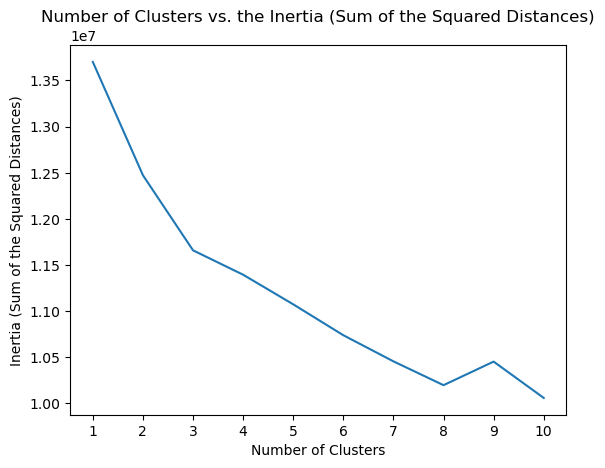

In [48]:
# Plot of the Number of Clusters vs. the Inertia of Mini Batch K-means Clustering

plt.plot(range(1, 11), list_of_inertia_for_each_K)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of the Squared Distances)")
plt.title("Number of Clusters vs. the Inertia (Sum of the Squared Distances)")
plt.show()

In [ ]:
# K-means Clustering with K=4 seems optimal because of the "elbow" point
# This probably adjusts to 3 with the updated info

# https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/

mbk = MiniBatchKMeans(init ='k-means++', 
                      n_clusters = 4,
                      batch_size = 100, 
                      n_init = 10,
                      max_no_improvement = 10, 
                      verbose = 0)

mbk.fit(X)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# Print out the cluster labels for each observation

print(mbk_means_labels)

[1 2 1 ... 2 1 2]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use your existing scaled data
print("Starting PCA...")

# Option: Specify the percentage of variance to retain (e.g., 95%)
pca = PCA(n_components=0.95)

# Fit PCA on your concatenated scaled data
X_pca = pca.fit_transform(X)  # X is your concatenated train+test data

# Rest of the PCA code remains the same...
print(f"Number of components selected: {pca.n_components_}")
print("Explained variance ratio per component:")
print(pca.explained_variance_ratio_)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print("\nCumulative explained variance:")
print(cumulative_explained_variance)

# Plotting the explained variance (Scree Plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='--', label='Individual explained variance')
plt.plot(range(1, pca.n_components_ + 1), cumulative_explained_variance, marker='o', linestyle='-', label='Cumulative explained variance')
plt.title('Scree Plot - Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, pca.n_components_ + 1)) # Ensure x-ticks match number of components
plt.legend(loc='best')
plt.grid(True)
plt.show()

# The transformed data X_pca can now be used for further analysis or as input to clustering algorithms
print(f"\nShape of data after PCA: {X_pca.shape}")
# PCA DataFrame
X_pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
print(X_pca_df.head())


In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming 'X_scaled' is your scaled feature matrix.
# Or, you might want to use 'X_pca' from the PCA step above.
# For demonstration, let's create a dummy X_scaled:
# X_scaled = pd.DataFrame(np.random.rand(100, 10)) # Replace with your actual X_scaled or X_pca

# --- Start of GMM ---
print("Starting GMM...")

# Define the range of components (clusters) to test
n_components_range = range(1, 11) # Example: 1 to 10 components
covariance_types = ['spherical', 'tied', 'diag', 'full'] # Common covariance types

# We'll use 'full' covariance for this example, but you should test others
# and select the best based on BIC/AIC or other criteria.
# For a fixed number of components (e.g., 4, to match your K-means)
n_clusters_gmm = 4 # Example, tune this parameter
gmm = GaussianMixture(n_components=n_clusters_gmm, covariance_type='full', random_state=42)

# Fit GMM
# If using PCA-transformed data: gmm.fit(X_pca)
gmm.fit(X_scaled)

# Get cluster assignments
gmm_labels = gmm.predict(X_scaled) # or X_pca
# Get probabilities of belonging to each cluster
gmm_probs = gmm.predict_proba(X_scaled) # or X_pca

print(f"\nCluster labels for the first 10 data points: {gmm_labels[:10]}")
# print(f"Probabilities for the first data point: {gmm_probs[0]}")
print(f"Number of clusters found: {len(np.unique(gmm_labels))}")

# To find the optimal number of components, you can iterate and check BIC/AIC
bics = []
aics = []

print("\nCalculating BIC and AIC for different numbers of components...")
for n_components in n_components_range:
    gmm_iter = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm_iter.fit(X_scaled) # or X_pca
    bics.append(gmm_iter.bic(X_scaled)) # or X_pca
    aics.append(gmm_iter.aic(X_scaled)) # or X_pca

# Plot BIC and AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, marker='o', label='BIC')
plt.plot(n_components_range, aics, marker='o', label='AIC')
plt.title('GMM: BIC and AIC for Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion Value (Lower is Better)')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# The optimal number of components is often where BIC/AIC is minimized.
# --- End of GMM ---

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors # For helping to choose eps
import matplotlib.pyplot as plt



print("Starting DBSCAN...")


min_samples_dbscan = 10 # Tune this parameter

print(f"Calculating k-distances for eps estimation (min_samples = {min_samples_dbscan})...")

neigh = NearestNeighbors(n_neighbors=min_samples_dbscan)
nbrs = neigh.fit(X_scaled) # or X_pca
distances, indices = nbrs.kneighbors(X_scaled) # or X_pca

# Sort the distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, min_samples_dbscan-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title(f'K-distance Graph (k={min_samples_dbscan}) for DBSCAN eps Estimation')
plt.xlabel('Points sorted by distance to k-th nearest neighbor')
plt.ylabel(f'{min_samples_dbscan}-th Nearest Neighbor Distance (eps candidate)')
plt.grid(True)
# Look for the "elbow" or "knee" in this plot to choose eps.
# This point indicates a region where distances start to increase sharply.
plt.show()
print("Review the K-distance plot above to choose a suitable 'eps' value (y-axis value at the 'elbow').")


# --- DBSCAN Clustering ---
# You need to set 'eps' based on the k-distance plot.
# Let's pick an example value for eps; YOU MUST TUNE THIS.
eps_dbscan = 0.5 # Example value, TUNE THIS CAREFULLY based on the plot above.

print(f"\nRunning DBSCAN with eps={eps_dbscan} and min_samples={min_samples_dbscan}...")
dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)

# Fit DBSCAN
# If using PCA-transformed data: dbscan.fit(X_pca)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Number of clusters in labels, ignoring noise if present.
# Noise points are labeled as -1.
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

print(f"\nEstimated number of clusters: {n_clusters_dbscan}")
print(f"Estimated number of noise points: {n_noise_dbscan}")
# print(f"Cluster labels: {np.unique(dbscan_labels)}") # Shows all unique labels including -1 for noise

# --- End of DBSCAN ---

## Business Question

**Can we predict the systematic risk (Beta) of mortgages in the FHFA NSMO portfolio using mortgage characteristics and macroeconomic factors?**

### Supervised Learning Questions

- **Which mortgage features (loan characteristics, borrower profiles, property details) are most predictive of mortgage Beta?**
- **How accurately can different ML models predict mortgage Beta?**
- **Which model family (probabilistic, tree-based, instance-based) performs best for this financial prediction task?**

### Unsupervised Learning Questions

- **Are there natural groupings/clusters of mortgages based on their characteristics?**
- **Do these clusters correspond to different risk profiles (Beta levels)?**
- **Can we identify mortgage segments that behave similarly in terms of systematic risk?**

### Financial/Business Questions

- **How do mortgage characteristics influence systematic risk relative to market movements?**
- **Can we identify high-Beta vs low-Beta mortgage profiles for portfolio management?**